## Multi-Head self Attention in AllenNLP

   Multi-headd Self Attention is implemented in modules.seq2seq_encoder
   
   Let's see how to use it 

In [ ]:
import numpy
import torch
import torch.nn as nn

from allennlp.modules.seq2seq_encoders import Seq2SeqEncoder,MultiHeadSelfAttention
from allennlp.common.params import Params
from allennlp.nn.util import masked_softmax,weighted_sum

In [1]:
from allennlp.common.params import Params

#define parameters of the model
params = Params({"num_heads": 3,
                "input_dim":2,
                "attention_dim":3,
                "values_dim": 6})

In [2]:
from allennlp.modules.seq2seq_encoders import Seq2SeqEncoder,MultiHeadSelfAttention
encoder = MultiHeadSelfAttention.from_params(params)
print( isinstance(encoder,MultiHeadSelfAttention))
print("The input dimension : " , encoder._input_dim )
print("THe output dimension : " , encoder._output_dim)

True
The input dimension :  2
THe output dimension :  2


# Implementation Detail

   ### Utility functions
   * Masking operation used in decoder
      * decoder don't look at future positions
   * weighted_sum 
      * perform matrix reshaping and multiplication of attention and values
   

In [14]:
import torch
import torch.nn as nn

def masked_softmax(vector:torch.Tensor,mask:torch.Tensor,dim:int = -1) -> torch.Tensor:
    
    if mask is None:
        result = torch.nn.functional.softmax(vector, dim=dim)
    else:
        mask = mask.float()
        while mask.dim() < vector.dim():
            mask = mask.unsqueeze(1)
        
        result = torch.nn.functional.softmax(vector * mask, dim = dim)
        result = result * mask
        result = result / (result.sum(dim = dim , keepdim = True) + 1e-13)
    return result

def weighted_sum(matrix: torch.Tensor, attention: torch.Tensor) -> torch.Tensor:

    if attention.dim() == 2 and matrix.dim() == 3:
        return attention.unsqueeze(1).bmm(matrix).squeeze(1)
    if attention.dim() == 3 and matrix.dim() == 3:
        return attention.bmm(matrix)
    if matrix.dim() - 1 < attention.dim():
        expanded_size = list(matrix.size())
        for i in range(attention.dim() - matrix.dim() + 1):
            matrix = matrix.unsqueeze(1)
            expanded_size.insert(i + 1, attention.size(i + 1))
        matrix = matrix.expand(*expanded_size)
    intermediate = attention.unsqueeze(-1).expand_as(matrix) * matrix
    return intermediate.sum(dim=-2)
           

# Multi-head Self Attention 
   ### Initialization
   
   Needs to initialize model
   parameters
       * number of heads
       * input dimension
       * attention dimension
       * value dimension
       * output projection dimension
    
![](MultiHead.png)
       

In [24]:
class mhsa(Seq2SeqEncoder):
    def __init__(self,
                num_heads:int,
                input_dim: int,
                attention_dim : int,
                values_dim: int,
                output_projection_dim: int = None,
                attention_dropout_prob: float=0.1) -> None:
        super(mhsa,self).__init__()
    
        # variable initialization 
        self._num_heads = num_heads
        self._input_dim = input_dim
        self._output_dim = output_projection_dim or input_dim
        self._attention_dim = attention_dim #d_k in paper
        self._values_dim = values_dim # d_v in paper

      
        # class methods 
        #  Projection -> Q , K , V all together
        self._combined_projection = nn.Linear(input_dim, 2 * attention_dim +
                                          values_dim)
        # the scaling factor -> sqrt(d_k)
        self._scale = (input_dim // num_heads)**0.5
        
        
        # dropout prob for self_attention
        self._attention_dropout = nn.Dropout(attention_dropout_prob)
        
        # output projection after attention computation
        self._output_projection = nn.Linear(values_dim,self._output_dim)
        
       
        print(self)
        
    def forward(self,
               inputs: torch.Tensor,
               mask: torch.LongTensor = None) -> torch.FloatTensor:
        
        """
        inputs : shape (bath_size,timesteps,input_dim)
        mask   : shape (batch_size,timesteps)
        
        Returns
        --------
        A tensor of shape (batch_size, timesteps, output_projection_dim)
        output_projection_dim = input_dim by default
        """
        
        num_heads = self._num_heads
        
        batch_size, timesteps, _ = inputs.size()
        if mask is None:
            mask = inputs.new_ones(batch_size,timesteps) # new_ones --> makes a new matrix with same shape?
            
        # Q, K, V combined projection    [Q,K,V] * I 
        combined_projection = self._combined_projection(inputs)
        
        # separate Q*I , K*I, and V*I
        queries, keys, *values = combined_projection.split(self._attention_dim,-1)

        # PyTorch internal indexing (don't care about)
        queries = queries.contiguous()
        keys = keys.contiguous()
        values = torch.cat(values, -1).contiguous()
        
        print(type(queries),queries.size())
        print(type(keys), keys.size())
        print(type(values),values.size())
        
        
        values_per_head = values.view(batch_size,timesteps,num_heads,
                                     int(self._values_dim/num_heads))
        values_per_head = values_per_head.transpose(1,2).contiguous()
        values_per_head = values_per_head.view(batch_size*num_heads, timesteps,
                                               int(self._values_dim/num_heads))
        
        queries_per_head = queries.view(batch_size,timesteps,num_heads,
                                    int(self._attention_dim/num_heads))
        queries_per_head = queries_per_head.transpose(1,2).contiguous()
        queries_per_head = queries_per_head.view(batch_size * num_heads,timesteps,
                                             int(self._attention_dim / num_heads))
        
        
        keys_per_head = keys.view(batch_size,timesteps,num_heads,
                                 int(self._attention_dim/num_heads))
        keys_per_head = keys_per_head.transpose(1,2).contiguous()
        keys_per_head = keys_per_head.view( batch_size * num_heads, timesteps,
                                           int(self._attention_dim/num_heads))
        
        scaled_similarities = torch.bmm(queries_per_head, 
                                        keys_per_head.transpose(1,2)) /self._scale
        
        # mask operation (for encoder it has no effect)
        mask_input = mask.repeat(1,num_heads).view(batch_size * num_heads, timesteps)
        
        # softmax      
        attention = masked_softmax(scaled_similarities,mask_input)
        
        # dropout of resulting weights
        attention = self._attention_dropout(attention)
        
        # weigth values by attention ( or similarity between Q and K)
        outputs = weighted_sum(values_per_head,attention)
        
        
        # now back to original shape 
        
        outputs = outputs.view(batch_size,num_heads, timesteps, 
                              int(self._values_dim / num_heads))
        outputs = outputs.transpose(1,2).contiguous()
        
        outputs = outputs.view(batch_size,timesteps, self._values_dim)
        
        
        # output projection to resulting concatenated multi head attention results
        outputs = self._output_projection(outputs)
        
        return outputs
        
        

In [25]:
# Initialize Multi-head attention
attention = mhsa(num_heads=3,
                   input_dim=5,
                   attention_dim=6,
                   values_dim=9,
                   attention_dropout_prob=0.0)

mhsa(
  (_combined_projection): Linear(in_features=5, out_features=21, bias=True)
  (_attention_dropout): Dropout(p=0.0)
  (_output_projection): Linear(in_features=9, out_features=5, bias=True)
)


In [26]:
# Apply Multi-Head Attention

inputs = torch.randn(2,12,5)
mask = torch.ones([2,12])
mask[0,6:]=0
attn = attention(inputs,mask)
print(attn)

<class 'torch.Tensor'> torch.Size([2, 12, 6])
<class 'torch.Tensor'> torch.Size([2, 12, 6])
<class 'torch.Tensor'> torch.Size([2, 12, 9])
tensor([[[ 0.4881, -0.3646,  0.2033,  0.6918,  0.0179],
         [ 0.4792, -0.3729,  0.2078,  0.6598, -0.0340],
         [ 0.4666, -0.3597,  0.2069,  0.6635, -0.0173],
         [ 0.3743, -0.1703,  0.3494,  0.5160,  0.0187],
         [ 0.4589, -0.2733,  0.2739,  0.5635,  0.0093],
         [ 0.5790, -0.4466,  0.1412,  0.7587,  0.0077],
         [ 0.4599, -0.3282,  0.2427,  0.5856, -0.0892],
         [ 0.5307, -0.3287,  0.1978,  0.6012, -0.1233],
         [ 0.5585, -0.3615,  0.1570,  0.6943, -0.0309],
         [ 0.4746, -0.2993,  0.2483,  0.5202, -0.1581],
         [ 0.4146, -0.3541,  0.2254,  0.6452, -0.0505],
         [ 0.4491, -0.2406,  0.2805,  0.5263, -0.0844]],

        [[ 0.3529, -0.1904,  0.1064,  0.2282, -0.2996],
         [ 0.3479, -0.1831,  0.1611,  0.3075, -0.2107],
         [ 0.4419, -0.0782,  0.1224,  0.4240, -0.0070],
         [ 0.4643, -

## Positional Encoding

In [27]:
def get_device_of(tensor: torch.Tensor) -> int:
    """
    Returns the device of the tensor
    """
    if not tensor.is_cuda:
        return -1
    else:
        return tensor.get_device()
    
def get_range_vector(size: int, device: int)->torch.Tensor:
    """
    Returns a range of vectors with the desired size, starting at 0.
    """
    if device > -1:
        return torch.cuda.LongTensor(size,device=device).fill_(1).cusum(0)-1
    else:
        return torch.arange(0,size,dtype= torch.long)
    
    


torch.Size([512, 1])


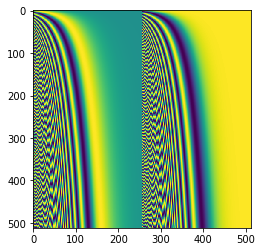

In [33]:
import math

tensor = torch.randn(1,512,512)

min_timescale= 1.0,
max_timescale = 1.0e4

_,timesteps, hidden_dim = tensor.size():

# get list of dimensions
timestep_range = get_range_vector(timesteps,get_device_of(tensor)).data.float()

# divide the dimension in half and name it timescales
# half sin and half cos
num_timescales = hidden_dim // 2

timescale_range = get_range_vector(num_timescales,get_device_of(tensor)).data.float()

# geometric progressions betwen 2* pi to 10000 * Pi
log_timescale_increments = math.log(float(1.0e4) /float(1.0))/float(num_timescales-1)

inverse_timescales = float(1.0) * torch.exp(timescale_range * -log_timescale_increments)

# dimension adjustment for 2D coordinate generation
scaled_time = timestep_range.unsqueeze(1) * inverse_timescales.unsqueeze(0)

%matplotlib inline
import matplotlib.pyplot as plt

# sin + cos transform 
sinusoids = torch.cat([torch.sin(scaled_time),torch.cos(scaled_time)],1).data.float()

plt.imshow(sinusoids)



## Stacked Self-Attetion Encoder

  ### Step 1:  This encoder combines 3 layers in a 'block':

    1. A 2 layer FeedForward network.
    2. Multi-headed self attention, which uses 2 learnt linear projections
       to perform a dot-product similarity between every pair of elements
       scaled by the square root of the sequence length.
    3. Layer Normalisation.

  ### Step2 : Blocks are then stacked into ``num_layers`` layers

In [34]:
class LayerNorm(torch.nn.Module):
    
    def __init__(self,
                dimension: int,
                eps: float = 1e-6)->None:
        super().__init__()
        self.gamma = torch.nn.Parameter(torch.ones(dimension))
        self.beta = torch.nn.Parameter(torch.zeros(dimension))
        self.eps = eps
        
    def forward(self,tensor:torch.Tensor):
        mean = tensor.mean(-1,keepdim=True)
        std = tensor.std(-1,unbiased=False,keepdim=True)
        return self.gamma * (tensor - mean) /(std + self.eps) + self.beta

In [ ]:

from typing import Sequence, Union
class FeedForward(torch.nn.Module):
    """
    FeedForwardy Layer with just a squeunce of Linear layers 
    with action functions in between
    num_layers : number of layers
    hidden_dims: Union[int, sequence[int]]
    activations: Union[Callable,Sequence[Callable]]
      the actiavtion function to use after each "Linear layer"
    dropout : uniton[float,Sequence[float]]
    
    """
    
    def __init__(self,
                input_dim: int,
                num_layers: int,
                hidden_dims: Union[int,Sequence[int]],
                activations: Union[Activation,Sequence[Activation]],
                dropout: Union[float,Sequence[float]]=0.0) -> None:
        super(FeedForward,self).__init__()
        if not isinstance(hidden_dims, list):
            hidden_dims = [hidden_dims] * num_layers
            print("Hidden layer dimensions : ", hidden_dims)
        if not isinstance(activations,list):
            activations = [activations] * num_layers
        if not isinstance(dropout,list):
            dropout =[dropout] * num_layers
        if len(hidden_dims) != num_layers:
            raise ConfigurationError("Error")
        if len(activations) != num_layers:
            raise ConfigurationError("Error")
        if len(dropout)!= num_layers:
            raise ConfigurationError("Error")
            
        self.activations = activations
        input_dim = [input_dim] + hidden_dims[:-1]
        print("input dimension : ", input_dim)
        linear_layers =[]
        for layer_input_dim, layer_output_dim in zip(input_dim, hidden_dims):
            linear_layers.append(torch.nn.Linear(layer_input_dim,layer_output_dim))
        self._linear_layers = torch.nn.ModuleList(linear_layers)
        dropout_layers = [torch.nn.Dropout(p=value) for value in dropout]
        
        
        self._dropout = torch.nn.ModuleList(dropout_layers)
        
        self._output_dim = hidden_dims[-1]
        
        self.input_dim = input_dim
        

In [ ]:
FeedForward(100, activations=[Activation.by_name('relu')(),
                              Activation.by_name('linear')()],
                hidden_dims = [30,30],
                num_layers = 2,
                dropout =0.1)

### StackedSelfAttentionEncoder from AllenNLP
![](allennlp_ssae.png)

In [35]:
from allennlp.modules import FeedForward
from allennlp.modules import Seq2SeqEncoder
from allennlp.nn.activations import Activation
from allennlp.nn.util import add_positional_features

class StackedSelfAttentionEncoder(Seq2SeqEncoder):

    
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 projection_dim: int,
                 feedforward_hidden_dim: int,
                 num_layers: int,
                 num_attention_heads: int,
                 use_positional_encoding: bool= True,
                 dropout_prob: float = 0.1,
                 residual_dropout_prob: float = 0.2,
                 attention_dropout_prob: float = 0.1) -> None:
        super(StackedSelfAttentionEncoder,self).__init__()
        
        self._use_positional_encoding = use_positional_encoding
        self._attention_layers: List[MultiHeadSelfAttention]=[]
        self._feedforward_layers: List[FeedForward]=[]
        self._layer_norm_layers: List[LayerNorm] =[]
        self._feed_forward_layer_norm_layers: List[LayerNorm]=[]
            
        #case when input_dim ~= hidden_dim
        ff_input_dim = input_dim
        
        # stack "num_layers" layers 
        for i in range(num_layers):
            # 2_layer_feed forward layer
            ff = FeedForward(ff_input_dim,
                             activations=[Activation.by_name('relu')(),
                                         Activation.by_name('linear')()],
                             hidden_dims = [feedforward_hidden_dim,hidden_dim],
                             num_layers = 2,
                             dropout = dropout_prob)
            self.add_module(f"feedforward_{i}",ff)
            self._feedforward_layers.append(ff)
            
            # Layer normalization to feed forward output
            ff_norm = LayerNorm(ff.get_output_dim())
            self.add_module(f"feedforward_layer_norm_{i}",ff_norm)
            self._feed_forward_layer_norm_layers.append(ff_norm)
            
            # Multi-Head self attention layer
            self_attention = mhsa(num_heads = num_attention_heads,
                                                   input_dim = hidden_dim,
                                                   attention_dim=projection_dim,
                                                   values_dim = projection_dim,
                                                   attention_dropout_prob = attention_dropout_prob)
            self.add_module(f"self_attention_{i}",self_attention)
            self._attention_layers.append(self_attention)
            
            # Layer normalization to attention output
            layer_norm = LayerNorm(self_attention._output_dim)
            self.add_module(f"layer_norm_{i}",layer_norm)
            self._layer_norm_layers.append(layer_norm)
            
            ff_input_dim = hidden_dim
            
        self.dropout = nn.Dropout(residual_dropout_prob)
        self._input_dim = input_dim
        
        # output dimension is the output vector size of the last encoder
        self._output_dim = self._attention_layers[-1]._output_dim
        
    def forward(self,
               inputs:torch.Tensor,
               mask: torch.Tensor):
        if self._use_positional_encoding:
            output = add_positional_features(inputs)
        else:
            output = inputs
        for (attention,  ff,  ff_norm, layer_norm) in 
                                zip(self._attention_layers,
                                    self._feedforward_layers,
                                    self._feed_forward_layer_norm_layers,
                                    self._layer_norm_layers):
            cached_input = output
            # Project output of attention encoder through a feedforward net
            # and back to the input size for next layer.
            # shape (batch_size, timesteps, input_size)
            
            ff_output = ff(output)
            ff_output = self.dropout(ff_output)
            if ff_output.size() == cached_input.size():
                ff_output = ff_norm(ff_output + cached_input)
            #shape (batch_size,timesteps, hidden_dim)
            attention_output = attention(ff_output,mask)
            output = layer_norm(self.dropout(attention_output) + ff_output)
        return output
                    
        
    
    
    

SyntaxError: invalid syntax (<ipython-input-35-ddc057be5916>, line 77)

In [ ]:
encoder = StackedSelfAttentionEncoder(input_dim=9,
                                     hidden_dim=12,
                                     projection_dim=6,
                                     feedforward_hidden_dim=5,
                                     num_layers=3,
                                     num_attention_heads=3)
# assert encoder.get_input_dim() ==9
# assert encoder.get_output_dim() ==12